# 动量法
:label:`sec_momentum`

在 :numref:`sec_sgd`一节中，我们详述了如何执行随机梯度下降，即在只有嘈杂的梯度可用的情况下执行优化时会发生什么。
对于嘈杂的梯度，我们在选择学习率需要格外谨慎。
如果衰减速度太快，收敛就会停滞。
相反，如果太宽松，我们可能无法收敛到最优解。

## 基础

本节将探讨更有效的优化算法，尤其是针对实验中常见的某些类型的优化问题。

### 泄漏平均值

上一节中我们讨论了小批量随机梯度下降作为加速计算的手段。
它也有很好的副作用，即平均梯度减小了方差。
小批量随机梯度下降可以通过以下方式计算：

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}.
$$

为了保持记法简单，在这里我们使用$\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$作为样本$i$的随机梯度下降，使用时间$t-1$时更新的权重$t-1$。
如果我们能够从方差减少的影响中受益，甚至超过小批量上的梯度平均值，那很不错。
完成这项任务的一种选择是用*泄漏平均值*（leaky average）取代梯度计算：

$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$$

其中$\beta \in (0, 1)$。
这有效地将瞬时梯度替换为多个“过去”梯度的平均值。
$\mathbf{v}$被称为*动量*（momentum），
它累加了过去的梯度。
为了更详细地解释，让我们递归地将$\mathbf{v}_t$扩展到

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$

其中，较大的$\beta$相当于长期平均值，而较小的$\beta$相对于梯度法只是略有修正。
新的梯度替换不再指向特定实例下降最陡的方向，而是指向过去梯度的加权平均值的方向。
这使我们能够实现对单批量计算平均值的大部分好处，而不产生实际计算其梯度的代价。

上述推理构成了"加速"梯度方法的基础，例如具有动量的梯度。
在优化问题条件不佳的情况下（例如，有些方向的进展比其他方向慢得多，类似狭窄的峡谷），"加速"梯度还额外享受更有效的好处。
此外，它们允许我们对随后的梯度计算平均值，以获得更稳定的下降方向。
诚然，即使是对于无噪声凸问题，加速度这方面也是动量如此起效的关键原因之一。

正如人们所期望的，由于其功效，动量是深度学习及其后优化中一个深入研究的主题。
例如，请参阅[文章](https://distill.pub/2017/momentum/）（作者是 :cite:`Goh.2017`)，观看深入分析和互动动画。
动量是由 :cite:`Polyak.1964`提出的。
 :cite:`Nesterov.2018`在凸优化的背景下进行了详细的理论讨论。
长期以来，深度学习的动量一直被认为是有益的。
有关实例的详细信息，请参阅 :cite:`Sutskever.Martens.Dahl.ea.2013`的讨论。

### 条件不佳的问题

为了更好地了解动量法的几何属性，我们复习一下梯度下降，尽管它的目标函数明显不那么令人愉快。
回想我们在 :numref:`sec_gd`中使用了$f(\mathbf{x}) = x_1^2 + 2 x_2^2$，即中度扭曲的椭球目标。
我们通过向$x_1$方向伸展它来进一步扭曲这个函数

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

与之前一样，$f$在$(0, 0)$有最小值，
该函数在$x_1$的方向上*非常*平坦。
让我们看看在这个新函数上执行梯度下降时会发生什么。


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_trace_2d(f, results):
    """显示优化过程中2D变量的轨迹"""
    # 设置图形大小
    plt.figure(figsize=(6, 4))
    
    # 绘制优化轨迹
    x_coords, y_coords = zip(*results)
    plt.plot(x_coords, y_coords, '-o', color='#ff7f0e')
    
    # 创建网格点用于绘制等高线
    x1_range = torch.arange(-5.5, 1.0, 0.1)
    x2_range = torch.arange(-3.0, 1.0, 0.1)
    x1, x2 = torch.meshgrid(x1_range, x2_range, indexing='ij')
    
    # 计算目标函数值并绘制等高线
    z = f(x1, x2)
    plt.contour(x1.numpy(), x2.numpy(), z.numpy(), colors='#1f77b4')
    
    # 添加坐标轴标签
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 显示图形
    plt.tight_layout()
    plt.show()

def train_2d(trainer, steps=20, f_grad=None):  #@save
    """用定制的训练机优化2D目标函数"""
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

epoch 20, x1: -0.943467, x2: -0.000073


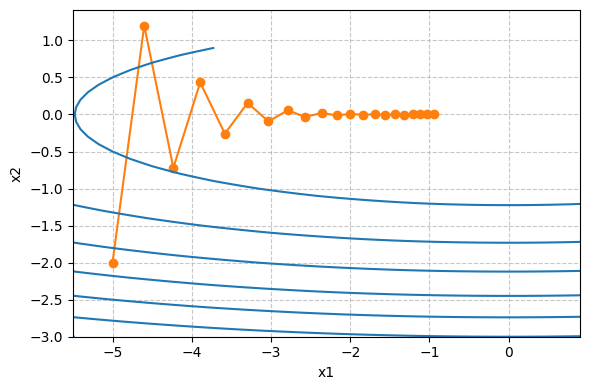

In [4]:
%matplotlib inline
import torch
# from d2l import torch as d2l

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

从构造来看，$x_2$方向的梯度比水平$x_1$方向的梯度大得多，变化也快得多。
因此，我们陷入两难：如果选择较小的学习率，我们会确保解不会在$x_2$方向发散，但要承受在$x_1$方向的缓慢收敛。相反，如果学习率较高，我们在$x_1$方向上进展很快，但在$x_2$方向将会发散。
下面的例子说明了即使学习率从$0.4$略微提高到$0.6$，也会发生变化。
$x_1$方向上的收敛有所改善，但整体来看解的质量更差了。


epoch 20, x1: -0.387814, x2: -1673.365109


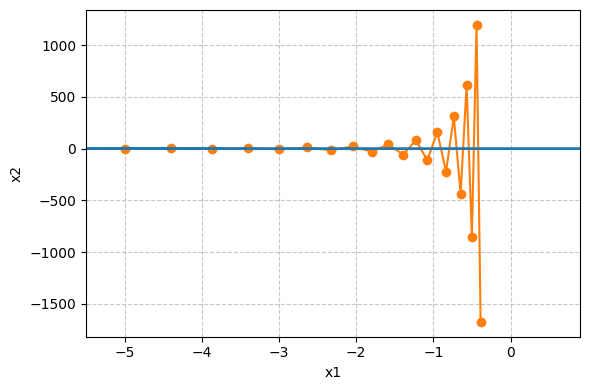

In [5]:
eta = 0.6
show_trace_2d(f_2d, train_2d(gd_2d))

### 动量法

*动量法*（momentum）使我们能够解决上面描述的梯度下降问题。
观察上面的优化轨迹，我们可能会直觉到计算过去的平均梯度效果会很好。
毕竟，在$x_1$方向上，这将聚合非常对齐的梯度，从而增加我们在每一步中覆盖的距离。
相反，在梯度振荡的$x_2$方向，由于相互抵消了对方的振荡，聚合梯度将减小步长大小。
使用$\mathbf{v}_t$而不是梯度$\mathbf{g}_t$可以生成以下更新等式：

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

请注意，对于$\beta = 0$，我们恢复常规的梯度下降。
在深入研究它的数学属性之前，让我们快速看一下算法在实验中的表现如何。


epoch 20, x1: 0.007188, x2: 0.002553


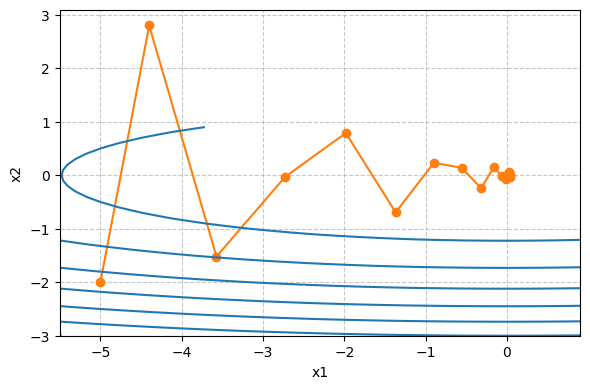

In [6]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

正如所见，尽管学习率与我们以前使用的相同，动量法仍然很好地收敛了。
让我们看看当降低动量参数时会发生什么。
将其减半至$\beta = 0.25$会导致一条几乎没有收敛的轨迹。
尽管如此，它比没有动量时解将会发散要好得多。


epoch 20, x1: -0.126340, x2: -0.186632


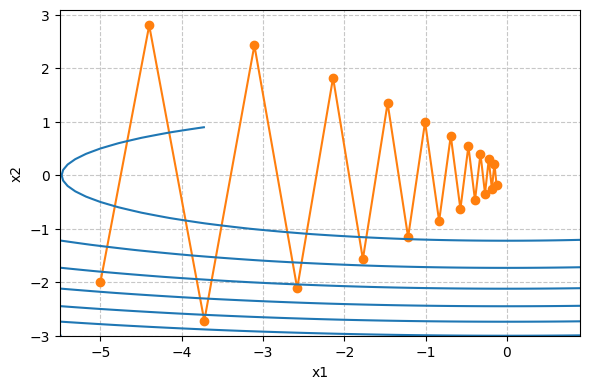

In [7]:
eta, beta = 0.6, 0.25
show_trace_2d(f_2d, train_2d(momentum_2d))

请注意，我们可以将动量法与随机梯度下降，特别是小批量随机梯度下降结合起来。
唯一的变化是，在这种情况下，我们将梯度$\mathbf{g}_{t, t-1}$替换为$\mathbf{g}_t$。
为了方便起见，我们在时间$t=0$初始化$\mathbf{v}_0 = 0$。

### 有效样本权重

回想一下$\mathbf{v}_t = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}$。
极限条件下，$\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$。
换句话说，不同于在梯度下降或者随机梯度下降中取步长$\eta$，我们选取步长$\frac{\eta}{1-\beta}$，同时处理潜在表现可能会更好的下降方向。
这是集两种好处于一身的做法。
为了说明$\beta$的不同选择的权重效果如何，请参考下面的图表。


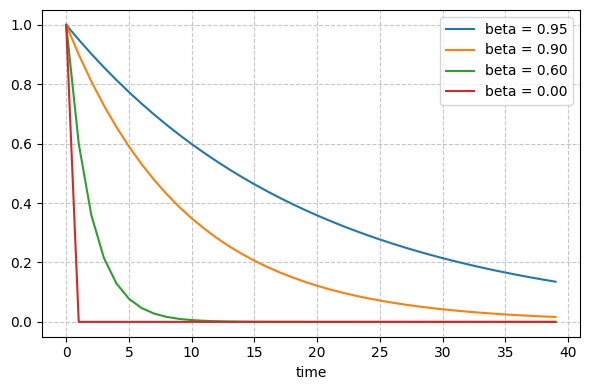

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 设置图形大小
plt.figure(figsize=(6, 4))

betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')

plt.xlabel('time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

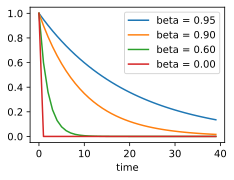

In [5]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

## 实际实验

让我们来看看动量法在实验中是如何运作的。
为此，我们需要一个更加可扩展的实现。

### 从零开始实现

相比于小批量随机梯度下降，动量方法需要维护一组辅助变量，即速度。
它与梯度以及优化问题的变量具有相同的形状。
在下面的实现中，我们称这些变量为`states`。


In [9]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

In [10]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

让我们看看它在实验中是如何运作的。


In [11]:
from IPython import display
import torch

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

import time
import numpy as np
import torch

class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: linreg(X, w, b), squared_loss
    # 训练模型
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

In [12]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def download_file(url, filename):
    """下载文件"""
    import urllib.request
    import os
    
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
    else:
        print(f"{filename} already exists.")
    return filename

def load_array(data_arrays, batch_size, is_train=True):
    """构建PyTorch数据迭代器"""
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)

# 数据集信息
DATA_HUB = {}
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['airfoil'] = (DATA_URL + 'airfoil_self_noise.dat',
                       '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    """
    获取空气动力学数据集
    
    参数:
    - batch_size: 批量大小
    - n: 使用的样本数量
    
    返回:
    - data_iter: 数据迭代器
    - feature_dim: 特征维度
    """
    # 下载数据
    url, sha1_hash = DATA_HUB['airfoil']
    filename = 'airfoil_self_noise.dat'
    download_file(url, filename)
    
    # 加载数据
    data = np.genfromtxt(filename, dtype=np.float32, delimiter='\t')
    
    # 数据标准化：移除均值并缩放方差为1
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    
    # 取前n个样本，特征为前几列，标签为最后一列
    features = torch.from_numpy(data[:n, :-1])
    labels = torch.from_numpy(data[:n, -1])
    
    # 创建数据加载器
    data_iter = load_array((features, labels), batch_size, is_train=True)
    
    # 返回数据迭代器和特征维度
    return data_iter, data.shape[1]-1

loss: 0.242, 0.008 sec/epoch


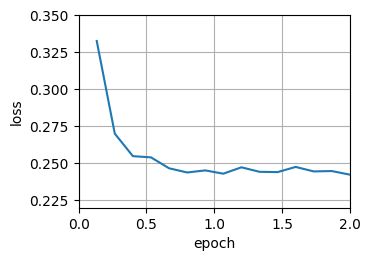

In [13]:
def train_momentum(lr, momentum, num_epochs=2):
    train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

当我们将动量超参数`momentum`增加到0.9时，它相当于有效样本数量增加到$\frac{1}{1 - 0.9} = 10$。
我们将学习率略微降至$0.01$，以确保可控。


loss: 0.247, 0.005 sec/epoch


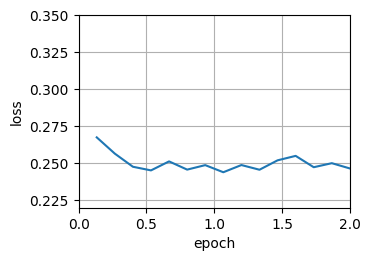

In [14]:
train_momentum(0.01, 0.9)

降低学习率进一步解决了任何非平滑优化问题的困难，将其设置为$0.005$会产生良好的收敛性能。


loss: 0.251, 0.005 sec/epoch


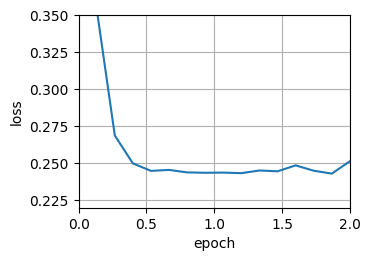

In [15]:
train_momentum(0.005, 0.9)

### 简洁实现

由于深度学习框架中的优化求解器早已构建了动量法，设置匹配参数会产生非常类似的轨迹。


In [18]:
from torch import nn
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.248, 0.006 sec/epoch


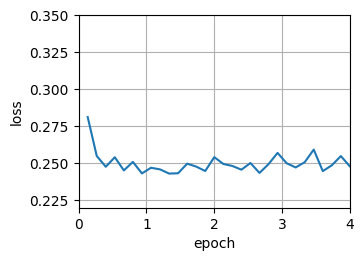

In [19]:
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

## 理论分析

$f(x) = 0.1 x_1^2 + 2 x_2^2$的2D示例似乎相当牵强。
下面我们将看到，它在实际生活中非常具有代表性，至少最小化凸二次目标函数的情况下是如此。

### 二次凸函数

考虑这个函数

$$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b.$$

这是一个普通的二次函数。
对于正定矩阵$\mathbf{Q} \succ 0$，即对于具有正特征值的矩阵，有最小化器为$\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$，最小值为$b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。
因此我们可以将$h$重写为

$$h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}.$$

梯度由$\partial_{\mathbf{x}} f(\mathbf{x}) = \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$给出。
也就是说，它是由$\mathbf{x}$和最小化器之间的距离乘以$\mathbf{Q}$所得出的。
因此，动量法还是$\mathbf{Q} (\mathbf{x}_t - \mathbf{Q}^{-1} \mathbf{c})$的线性组合。

由于$\mathbf{Q}$是正定的，因此可以通过$\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$分解为正交（旋转）矩阵$\mathbf{O}$和正特征值的对角矩阵$\boldsymbol{\Lambda}$。
这使我们能够将变量从$\mathbf{x}$更改为$\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$，以获得一个非常简化的表达式：

$$h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'.$$

这里$b' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。
由于$\mathbf{O}$只是一个正交矩阵，因此不会真正意义上扰动梯度。
以$\mathbf{z}$表示的梯度下降变成

$$\mathbf{z}_t = \mathbf{z}_{t-1} - \boldsymbol{\Lambda} \mathbf{z}_{t-1} = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1}.$$

这个表达式中的重要事实是梯度下降在不同的特征空间之间不会混合。
也就是说，如果用$\mathbf{Q}$的特征系统来表示，优化问题是以逐坐标顺序的方式进行的。
这在动量法中也适用。

$$\begin{aligned}
\mathbf{v}_t & = \beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1} \\
\mathbf{z}_t & = \mathbf{z}_{t-1} - \eta \left(\beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}\right) \\
    & = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}_{t-1} - \eta \beta \mathbf{v}_{t-1}.
\end{aligned}$$

在这样做的过程中，我们只是证明了以下定理：带有和带有不凸二次函数动量的梯度下降，可以分解为朝二次矩阵特征向量方向坐标顺序的优化。

### 标量函数

鉴于上述结果，让我们看看当我们最小化函数$f(x) = \frac{\lambda}{2} x^2$时会发生什么。
对于梯度下降我们有

$$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.$$

每$|1 - \eta \lambda| < 1$时，这种优化以指数速度收敛，因为在$t$步之后我们可以得到$x_t = (1 - \eta \lambda)^t x_0$。
这显示了在我们将学习率$\eta$提高到$\eta \lambda = 1$之前，收敛率最初是如何提高的。
超过该数值之后，梯度开始发散，对于$\eta \lambda > 2$而言，优化问题将会发散。


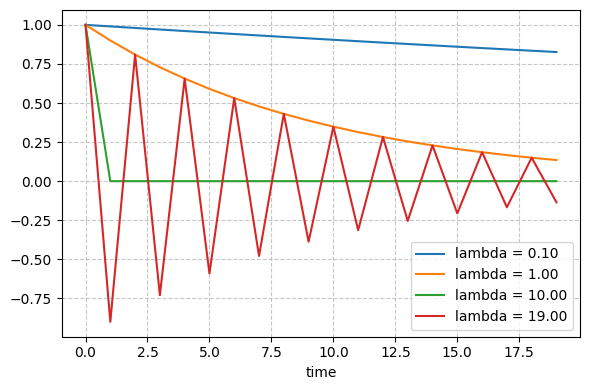

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 设置图形大小
plt.figure(figsize=(6, 4))

lambdas = [0.1, 1, 10, 19]
eta = 0.1

for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')

plt.xlabel('time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

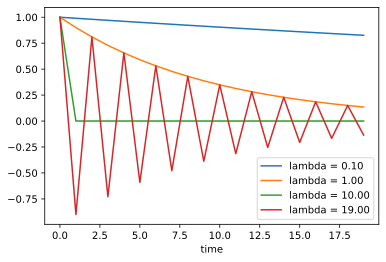

In [12]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

为了分析动量的收敛情况，我们首先用两个标量重写更新方程：一个用于$x$，另一个用于动量$v$。这产生了：

$$
\begin{bmatrix} v_{t+1} \\ x_{t+1} \end{bmatrix} =
\begin{bmatrix} \beta & \lambda \\ -\eta \beta & (1 - \eta \lambda) \end{bmatrix}
\begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}(\beta, \eta, \lambda) \begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix}.
$$

我们用$\mathbf{R}$来表示$2 \times 2$管理的收敛表现。
在$t$步之后，最初的值$[v_0, x_0]$变为$\mathbf{R}(\beta, \eta, \lambda)^t [v_0, x_0]$。
因此，收敛速度是由$\mathbf{R}$的特征值决定的。
请参阅[文章](https://distill.pub/2017/momentum/) :cite:`Goh.2017`了解精彩动画。
请参阅 :cite:`Flammarion.Bach.2015`了解详细分析。
简而言之，当$0 < \eta \lambda < 2 + 2 \beta$时动量收敛。
与梯度下降的$0 < \eta \lambda < 2$相比，这是更大范围的可行参数。
另外，一般而言较大值的$\beta$是可取的。

## 小结

* 动量法用过去梯度的平均值来替换梯度，这大大加快了收敛速度。
* 对于无噪声梯度下降和嘈杂随机梯度下降，动量法都是可取的。
* 动量法可以防止在随机梯度下降的优化过程停滞的问题。
* 由于对过去的数据进行了指数降权，有效梯度数为$\frac{1}{1-\beta}$。
* 在凸二次问题中，可以对动量法进行明确而详细的分析。
* 动量法的实现非常简单，但它需要我们存储额外的状态向量（动量$\mathbf{v}$）。

## 练习

1. 使用动量超参数和学习率的其他组合，观察和分析不同的实验结果。
1. 试试梯度下降和动量法来解决一个二次问题，其中有多个特征值，即$f(x) = \frac{1}{2} \sum_i \lambda_i x_i^2$，例如$\lambda_i = 2^{-i}$。绘制出$x$的值在初始化$x_i = 1$时如何下降。
1. 推导$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$的最小值和最小化器。
1. 当我们执行带动量法的随机梯度下降时会有什么变化？当我们使用带动量法的小批量随机梯度下降时会发生什么？试验参数如何？


[Discussions](https://discuss.d2l.ai/t/4328)
